In [1]:
from pyspark.sql import functions as F
from sklearn.cluster import DBSCAN, KMeans
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import folium
from folium.plugins import HeatMap, MarkerCluster
from pyspark.ml.feature import StringIndexer, OneHotEncoder
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
data_path = "data/Crime_Data_from_2020_to_Present_20241013.csv"

In [3]:
%load_ext autoreload
%autoreload 2
import sys; 
import sys; sys.path.insert(0, 'lib/')
from libs import utils

In [4]:
# Read and Clean Data
df = utils.prepare_data(data_path)
# Additional feature engineering - add more features
df = utils.feature_engineering(df)
columns_drop = ["AREA NAME", "Rpt Dist No", "Part 1-2", "Crm Cd", "Crm Cd Desc", "Mocodes", "Premis Cd","Premis Desc", "Weapon Used Cd", "Weapon Desc", "Status Desc", "LOCATION", "age_group"]
df_dropped = utils.drop_columns(df, columns_drop)
df_dropped = df_dropped.drop("DATE OCC", "TIME OCC", "datetime_str", "Date Rptd")
df_clean = df_dropped.dropna(subset=["Vict Age"])
df_clean.show()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/20 15:49:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/10/20 15:49:12 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


+----+--------+--------+--------------------+------+-------+---------+--------+---------+-------+------------------+
|AREA|Vict Age|Vict Sex|        Vict Descent|Status|    LAT|      LON|Year OCC|Month OCC|Day OCC|          Category|
+----+--------+--------+--------------------+------+-------+---------+--------+---------+-------+------------------+
|   1|      47|       M|               Other|    IC|34.0444|-118.2628|    2020|        2|      8|              BTFV|
|   3|      19|       X|             Unknown|    IC| 34.021|-118.3002|    2020|       11|      4|       OTHER THEFT|
|   9|      19|       M|               Other|    IC|34.1576|-118.4387|    2020|        3|     10|       OTHER THEFT|
|   6|      28|       M|Hispanic/Latin/Me...|    IC|34.0944|-118.3277|    2020|        8|     17|    IDENTITY THEFT|
|  18|      41|       M|Hispanic/Latin/Me...|    IC|33.9467|-118.2463|    2020|       12|      1|    IDENTITY THEFT|
|   1|      25|       M|Hispanic/Latin/Me...|    IC|34.0415| -11

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 49354)
Traceback (most recent call last):
  File "/Users/siowchuen/anaconda3/envs/pyspark_env/lib/python3.12/socketserver.py", line 318, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Users/siowchuen/anaconda3/envs/pyspark_env/lib/python3.12/socketserver.py", line 349, in process_request
    self.finish_request(request, client_address)
  File "/Users/siowchuen/anaconda3/envs/pyspark_env/lib/python3.12/socketserver.py", line 362, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Users/siowchuen/anaconda3/envs/pyspark_env/lib/python3.12/socketserver.py", line 761, in __init__
    self.handle()
  File "/Users/siowchuen/anaconda3/envs/pyspark_env/lib/python3.12/site-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/Users/siowchuen/anaconda3/envs/pyspark_env/lib/python3.12

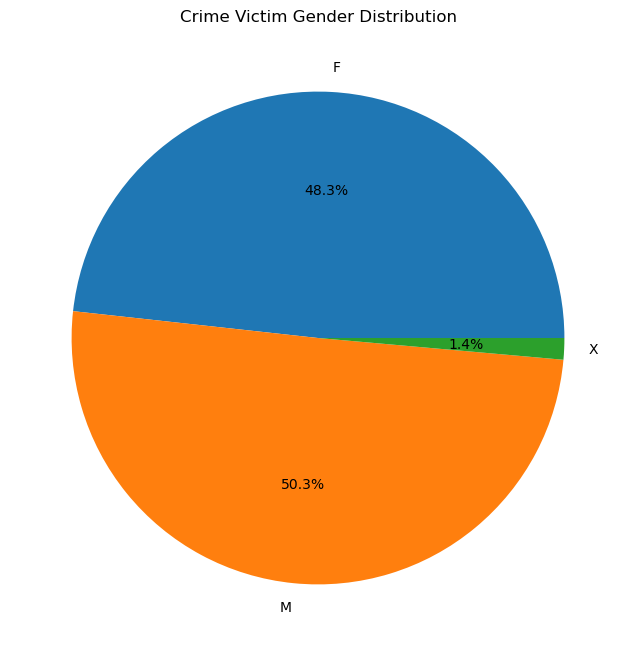

In [8]:
df_vict_sex = df_clean.groupby("Vict Sex").agg(F.count("Vict Sex").alias("Gender")).collect()
labels = [row["Vict Sex"] for row in df_vict_sex]
sizes = [row["Gender"] for row in df_vict_sex]

plt.figure(figsize=(8,8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title("Crime Victim Gender Distribution")
plt.show()

In [12]:
year_list = df_clean.select("Year OCC").distinct().collect()
year_list = [row["Year OCC"] for row in year_list]
print(year_list)

[2020, 2021, 2022, 2023, 2024]


[[22323, 19517, 17544, 16267, 15075, 11310, 10783, 9462, 9358, 6790], [24473, 20608, 17307, 16164, 15395, 12429, 11570, 11469, 9277, 6920], [26709, 22566, 22503, 19176, 17151, 14273, 12561, 12049, 9977, 7263], [24533, 23134, 19896, 16777, 13810, 13498, 12404, 11611, 10584, 6820], [12596, 12243, 6635, 5551, 4930, 4638, 3683, 3437, 3191, 2126], [140, 196, 350, 400, 414, 666, 1067, 1575, 1875, 6356], [143, 168, 342, 394, 406, 878, 1094, 1633, 1786, 6820], [166, 202, 297, 390, 460, 1075, 1612, 1796, 2084, 6771], [129, 134, 324, 340, 410, 1440, 1523, 2096, 2247, 6811], [1, 34, 53, 79, 90, 179, 323, 603, 1145, 1188]]


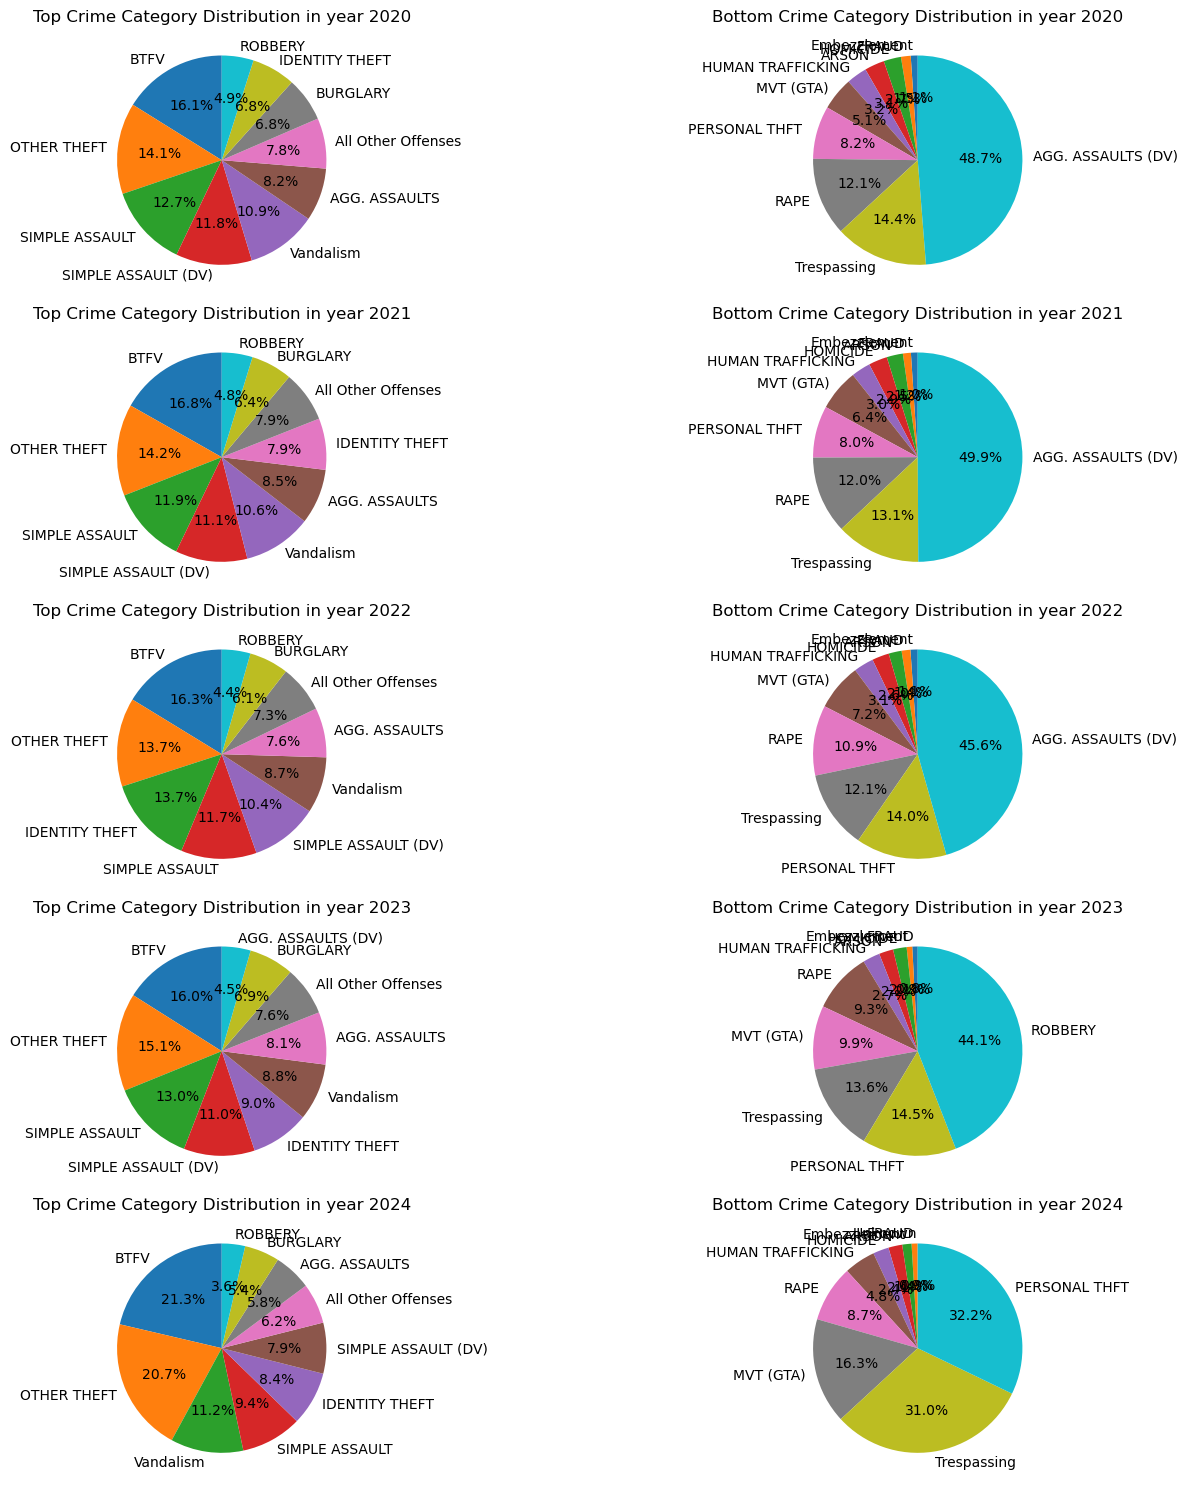

In [25]:
fig, axes = plt.subplots(5, 2, figsize=(15, 15))
axes = axes.flatten()
labels_list = []
sizes_list = []
titles_list = []
for yr in year_list:
    df_crime_year = df_clean.filter(F.col("Year OCC") == yr)
    df_crime_cat = df_crime_year.groupby(F.col("Category")).count()
    topten_df = df_crime_cat.orderBy(F.desc("count"))
    bottomten_df = df_crime_cat.orderBy("count")
    topten = topten_df.limit(10).collect()
    bottomten = bottomten_df.limit(10).collect()
    
    t_labels = [row["Category"] for row in topten]
    t_sizes = [row["count"] for row in topten]
    t_titles = f"Top Crime Category Distribution in year {yr}"
    b_labels = [row["Category"] for row in bottomten]
    b_sizes = [row["count"] for row in bottomten]
    b_titles = f"Bottom Crime Category Distribution in year {yr}"
    
    labels_list.append(t_labels)
    sizes_list.append(t_sizes)
    titles_list.append(t_titles)
    labels_list.append(b_labels)
    sizes_list.append(b_sizes)
    titles_list.append(b_titles)


print(sizes)
    
for i in range(10):
    axes[i].pie(sizes_list[i], labels=labels_list[i], autopct="%1.1f%%", startangle=90) 
    axes[i].set_title(titles_list[i])  
plt.tight_layout()
plt.show()
    
    
    

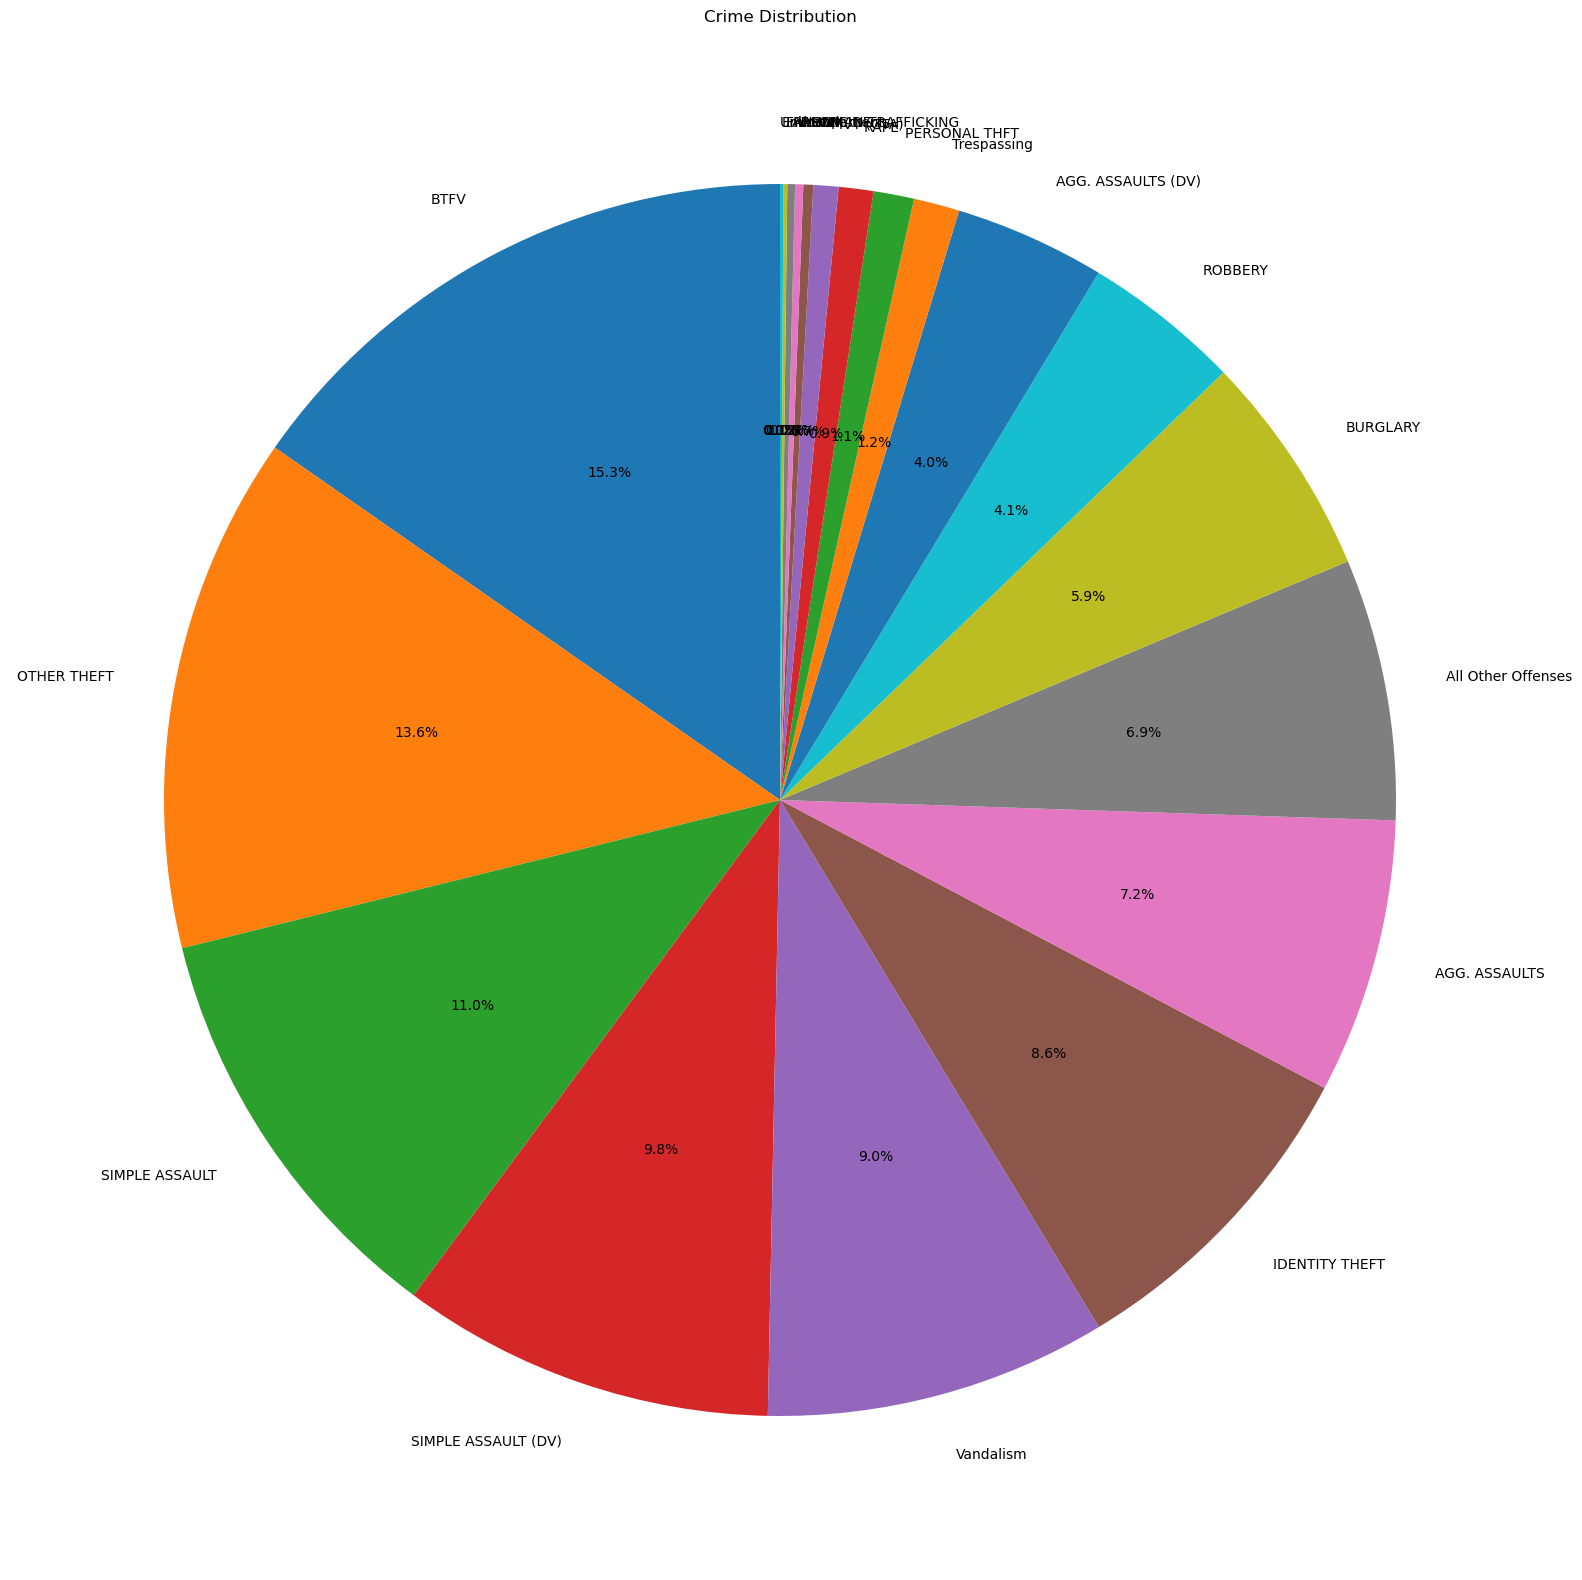

In [31]:
df_overall_cat = df_clean.groupBy(F.col("Category")).count().orderBy(F.desc("count")).collect()
labels = [row["Category"] for row in df_overall_cat]
sizes = [row['count'] for row in df_overall_cat]
plt.figure(figsize=(20, 20))
plt.pie(sizes, labels=labels,autopct="%1.1f%%", startangle=90)
plt.title("Crime Distribution")
plt.show()

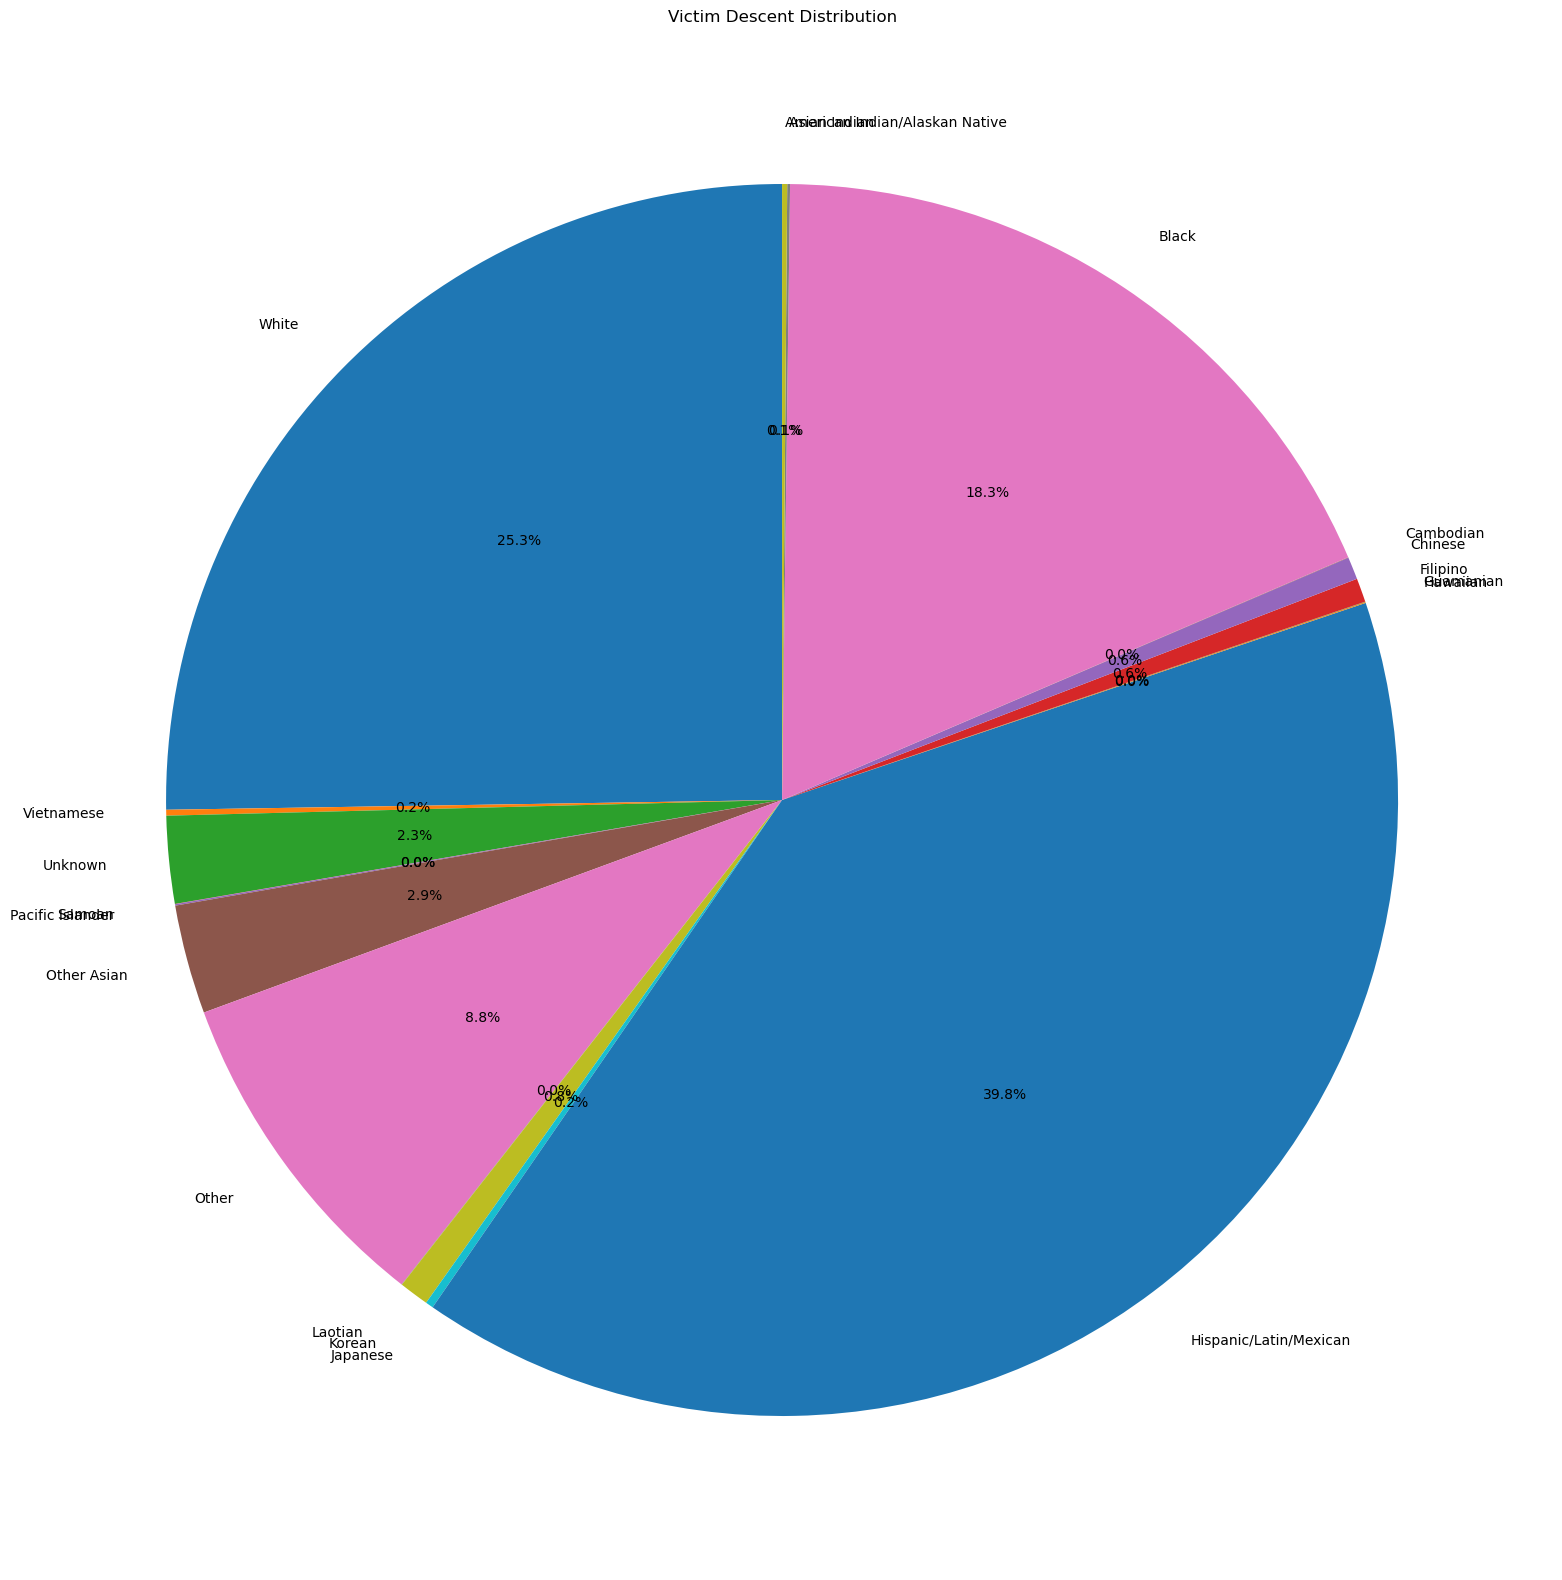

In [32]:
df_descent = df_clean.groupBy(F.col("Vict Descent")).count().orderBy(F.desc("Vict Descent")).collect()
labels = [row["Vict Descent"] for row in df_descent]
sizes = [row['count'] for row in df_descent]
plt.figure(figsize=(20, 20))
plt.pie(sizes, labels=labels,autopct="%1.1f%%", startangle=90)
plt.title("Victim Descent Distribution")
plt.show()